<div class="alert alert-block alert-danger">
    Toteutettu Python 3.12.4:llä
</div>

In [ ]:
%pip install pandas matplotlib plotly dash

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import HTML
from dash import Dash, dcc, html, Input, Output
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Projektin kuvaus

Projektin tavoitteena on analysoida pelaajien suoriutumista jalkapallon Valioliigan kaudella 23/24 kurssilla esiteltyjä työkaluja hyödyntäen. Työkirja on mahdollisuuksien mukaan pyritty strukturoimaan dataprojektin tyypillisten työvaiheiden mukaisesti, ja se sisältää linkkejä hyödylliseen dokumentaatioon osioiden aiheisiin liittyen.


## Projektissa käytettävä datasetti

Datasetti on peräisin [Kagglesta](https://www.kaggle.com/datasets/whisperingkahuna/premier-league-2324-team-and-player-insights/data), ja se tarjoaa kattavan tilastot jalkapallon Valioliigan kaudesta 2023/24, sisältäen dataa joukkueiden ja pelaajien suorituksista kaikilta ottelukierroksilta. Yhteensä datasetti koostuu yli 50 CSV-tiedostosta, joista jokainen keskittyy pelin tiettyihin osa-alueisiin. Datasetti sisältää muun muassa:
- **Joukkueiden suoritusmittarit**: Tarkat syötöt, päästetyt maalit, katkot jne.
- **Pelaajien suoritusmittarit**: Maaliodottama (xG), syötöt, voitetut taklaukset jne.
- **Ottelukohtaiset tiedot**: Tehdyt maalit, pallonhallintaprosentit, annetut kortit jne.
- **Sarjataulukot**: Sijoitukset, koti/vieras-suoritukset, ja edistyneet mittarit kuten xG ja xA.

Datasettiin kuuluvien tiedostojen tarkempi erittely tehdään hieman alempana.


## Datan lukeminen ja siivoaminen 

Kaggle tarjoaa useita vaihtoehtoisia tapoja datan tallentamiseen ja lukemiseen. Tämän projektin kohdalla päädyttiin viemään data GitHubiin, jotta ajaminen onnistuu helposti ilman erillisiä tiedostoja tai toimenpiteitä.
Data luetaan Pandas DataFrameihin GitHubista analysointia varten.

Rakennetaan yksinkertainen funktio tiedostojen GitHubista lukemista varten:

In [3]:
def readFile (filename, inMainDir = True):
    filename = filename.strip()
    baseURL = "https://raw.githubusercontent.com/mikaelkankaanpaa/datatie2025_mk/main/project/data/"
    if inMainDir:
        url = f"{baseURL}Premleg_23_24/{filename}"
    else:
        url = f"{baseURL}{filename}"

    try:
        df = pd.read_csv(url)
    except Exception as e:
        print(f"Dataa ei voitu lukea. Tarkista tiedoston nimi!\nVirheilmoitus: {e}")
        df = None
    return df

Luetaan ensin datasetin mukana tuleva CSV-tiedosto, joka sisältää kuvauksen kaikista sen sisältämistä datatiedostoista ja niiden sarakkeista.

- *Ison taulukon näyttäminen kokonaan vie tilaa eikä ole kovinkaan tyylikästä -> näytetään sen sijaan skrollattavana taulukkona tilan säästämiseksi hyödyntämällä IPythonin HTML-displaytä. (ks. https://stackoverflow.com/questions/42724327/pandas-dataframe-table-vertical-scrollbars 2. vastaus)*

In [4]:
# luetaan datasetin sisältämien tiedostojen kuvaustiedot dataframeen
detailsDF = readFile("Premleg_23_24_file_details.csv", inMainDir = False)
detailsDF = detailsDF.sort_values(by='File_name', ascending=True)
# display(detailsDF)

# muutetaan html:ksi jotta df voidaan näyttää skrollattavana taulukkona
htmlDF = detailsDF.to_html(index=False)
fullDiv = f"""
<div style="height:300px; overflow:auto;">
    {htmlDF}
</div>
"""
display(HTML(fullDiv))


File_name,Column_names
accurate_cross_team.csv,"Rank, Team, Accurate Crosses per Match, Cross Success (%), Matches, Country"
accurate_long_balls_team.csv,"Rank, Team, Accurate Long Balls per Match, Successful Long Balls (%), Matches, Country"
accurate_pass_team.csv,"Rank, Team, Accurate Passes per Match, Pass Success (%), Matches, Country"
big_chance_missed_team.csv,"Rank, Team, Big Chances Missed, Goals, Matches, Country"
big_chance_team.csv,"Rank, Team, Big Chances, Goals, Matches, Country"
clean_sheet_team.csv,"Rank, Team, Clean Sheets, Matches, Country"
corner_taken_team.csv,"Rank, Team, Corners Taken, Matches, Country"
effective_clearance_team.csv,"Rank, Team, Clearances per Match, Total Clearances, Matches, Country"
expected_goals_conceded_team.csv,"Rank, Team, Expected Goals Conceded, Goals Conceded, Matches, Country"
expected_goals_team.csv,"Rank, Team, Expected Goals, Goals, Matches, Country"


Käytetään pelaajien suoritusten analysointiin seuraavia tietoja:
- Pelaajan pelaamat ottelut
- Pelaajan peliminuutit
- Pelaajan tekemät pelitilannemaalit
- Pelaajan tekemät pilkkumaalit
- Pelaajan syöttöodottama (xA) ja toteutuneet maalisyötöt
- Pelaajan luomat maalipaikat
- Pelaajan saamat kortit
- Pelaajan keskimääräinen FotMob -rating kauden aikana

Luetaan seuraavaksi nämä tiedot sisältävät CSV-tiedostot datasetistä, ja muodostetaan yleiskäsitys niiden sisällöstä:

In [5]:
# Määritetään relevantit tiedostot ja niitä vastaavat dataframet
filesAndNames = {
    "player_top_scorers.csv": "topScorersDF",
    "player_expected_goals.csv": "xGoalsDF",
    "player_expected_assists.csv": "xAssistsDF",
    "player_big_chances_created.csv": "chancesCreatedDF",
    "player_yellow_cards.csv": "bookingsDF",
    "player_player_ratings.csv": "ratingsDF"
}

# Luetaan kukin listatuista tiedostoista ja nimetään ne listan mukaan;
# printataan lisäksi infot kullekin dataframelle
for filename, dfName in filesAndNames.items():
    globals()[dfName] = readFile(filename)
    print(f"DataFrame: {dfName}")
    display(globals()[dfName].info())
    

DataFrame: topScorersDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rank       298 non-null    int64  
 1   Player     298 non-null    object 
 2   Team       298 non-null    object 
 3   Goals      298 non-null    float64
 4   Penalties  298 non-null    float64
 5   Minutes    298 non-null    int64  
 6   Matches    298 non-null    int64  
 7   Country    298 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 18.8+ KB


None

DataFrame: xGoalsDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank                 460 non-null    int64  
 1   Player               460 non-null    object 
 2   Team                 460 non-null    object 
 3   Expected Goals (xG)  460 non-null    float64
 4   Actual Goals         460 non-null    float64
 5   Minutes              460 non-null    int64  
 6   Matches              460 non-null    int64  
 7   Country              460 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 28.9+ KB


None

DataFrame: xAssistsDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   559 non-null    int64  
 1   Player                 559 non-null    object 
 2   Team                   559 non-null    object 
 3   Expected Assists (xA)  559 non-null    float64
 4   Actual Assists         559 non-null    float64
 5   Minutes                559 non-null    int64  
 6   Matches                559 non-null    int64  
 7   Country                559 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 35.1+ KB


None

DataFrame: chancesCreatedDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank                 325 non-null    int64  
 1   Player               325 non-null    object 
 2   Team                 325 non-null    object 
 3   Big Chances Created  325 non-null    float64
 4   Total Assists        325 non-null    float64
 5   Minutes              325 non-null    int64  
 6   Matches              325 non-null    int64  
 7   Country              325 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 20.4+ KB


None

DataFrame: bookingsDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          438 non-null    int64  
 1   Player        438 non-null    object 
 2   Team          438 non-null    object 
 3   Yellow Cards  438 non-null    float64
 4   Red Cards     438 non-null    float64
 5   Minutes       438 non-null    int64  
 6   Matches       438 non-null    int64  
 7   Country       438 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 27.5+ KB


None

DataFrame: ratingsDF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        284 non-null    int64  
 1   Player                      284 non-null    object 
 2   Team                        284 non-null    object 
 3   FotMob Rating               284 non-null    float64
 4   Player of the Match Awards  284 non-null    float64
 5   Minutes                     284 non-null    int64  
 6   Matches                     284 non-null    int64  
 7   Country                     284 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 17.9+ KB


None

Yhdessäkään dataframessa ei näytä olevan NULL-arvoja, ja datatyypitkin vaikuttavat sopivilta, eli varsinaiset siivoustarpeet tällä datalla ovat minimaalisia. Dataframeissa on kuitenkin varsin vaihteleva määrä rivejä, sillä tiedostoihin ei ole sisällytetty nolla-arvoja. Yhdistetään dataframet xGoalsDF:ään, jotta relevantit tilastot saadaan kootusti yhteen dataframeen, ja korvataan puuttuvat arvot (=nolla-arvot) nollalla.

In [6]:
allStatsDF = xGoalsDF.merge(
    topScorersDF[["Player", "Penalties"]],
    on="Player",
    how="left"
).merge(
    xAssistsDF[["Player", "Expected Assists (xA)", "Actual Assists"]],
    on="Player",
    how="left"
).merge(
    chancesCreatedDF[["Player", "Big Chances Created"]],
    on="Player",
    how="left"
).merge(
    bookingsDF[["Player", "Yellow Cards", "Red Cards"]],
    on="Player",
    how="left"
).merge(
    ratingsDF[["Player", "FotMob Rating"]],
    on="Player",
    how="left"
).fillna(0)

display(allStatsDF.info())
display(allStatsDF.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   460 non-null    int64  
 1   Player                 460 non-null    object 
 2   Team                   460 non-null    object 
 3   Expected Goals (xG)    460 non-null    float64
 4   Actual Goals           460 non-null    float64
 5   Minutes                460 non-null    int64  
 6   Matches                460 non-null    int64  
 7   Country                460 non-null    object 
 8   Penalties              460 non-null    float64
 9   Expected Assists (xA)  460 non-null    float64
 10  Actual Assists         460 non-null    float64
 11  Big Chances Created    460 non-null    float64
 12  Yellow Cards           460 non-null    float64
 13  Red Cards              460 non-null    float64
 14  FotMob Rating          460 non-null    float64
dtypes: flo

None

,Rank,Player,Team,Expected Goals (xG),Actual Goals,Minutes,Matches,Country,Penalties,Expected Assists (xA),Actual Assists,Big Chances Created,Yellow Cards,Red Cards,FotMob Rating
0,1,Erling Haaland,Manchester City,29.3,27.0,2556,31,NOR,7.0,2.2,5.0,6.0,1.0,0.0,7.64
1,2,Mohamed Salah,Liverpool,21.2,18.0,2535,32,EGY,5.0,7.5,10.0,22.0,2.0,0.0,7.64
2,3,Alexander Isak,Newcastle United,20.3,21.0,2265,30,SWE,5.0,2.8,2.0,5.0,1.0,0.0,7.37
3,4,Dominic Solanke,Bournemouth,19.6,19.0,3331,38,ENG,2.0,2.0,3.0,3.0,3.0,0.0,7.05
4,5,Nicolas Jackson,Chelsea,18.6,14.0,2804,35,SEN,0.0,2.9,5.0,8.0,10.0,0.0,7.18


## Datan muokkaaminen & jalostaminen 

Datassa ei ole omaa saraketta pelitilannemaaleille (ts. ei-pilkkumaaleille); lisätään se. Uudelleennimetään samalla "Actual Goals" -> "Total Goals":

In [7]:
allStatsDF.rename(columns={"Actual Goals": "Total Goals"}, inplace=True)

allStatsDF.insert(
    loc = 5,
    column ="Non-Penalty Goals",
    value = allStatsDF["Total Goals"] - allStatsDF["Penalties"]
)

Lisätään myös sarakkeet "Goals per Game", "Goals per 90 Min", "Assists per Game" ja "Assists per 90 Min", jotka nimensä mukaisesti kertovat pelikohtaisen maali- ja syöttömäärän (ts. nämä normalisoidaan suhteessa pelattuihin otteluihin/peliaikaan). Käytetään peliajan suhteen yksikkönä maalia/syöttöä per 90 min, joka on helpommin tulkittava kuin esim. maalia minuutissa. <br>

Järjestetään myös dataframen sarakkeet uudelleen.

In [8]:
# Lisäsarakkeet
allStatsDF["Goals per Game"] = allStatsDF["Total Goals"] / allStatsDF["Matches"]
allStatsDF["Goals per 90 Min"] = allStatsDF["Total Goals"] / (allStatsDF["Minutes"] / 90)
allStatsDF["Assists per Game"] = allStatsDF["Actual Assists"] / allStatsDF["Matches"]
allStatsDF["Assists per 90 Min"] = allStatsDF["Actual Assists"] / (allStatsDF["Minutes"] / 90)

allStatsDF.drop(columns=["Rank"])

# Järjestetään sarakkeet uudelleen
allStatsDF = allStatsDF.reindex(columns=[
    "Player", "Team", "Expected Goals (xG)", "Total Goals", 
    "Non-Penalty Goals", "Penalties", "Goals per Game", "Goals per 90 Min", 
    "Expected Assists (xA)", "Actual Assists", "Assists per Game", "Assists per 90 Min",  
    "Big Chances Created", "Yellow Cards", "Red Cards", "FotMob Rating", "Minutes", 
    "Matches", "Country"
])

# Testataan viidellä satunnaisella pelaajalla:
display(allStatsDF.sample(5).sort_values(by="Goals per Game", ascending=False))

,Player,Team,Expected Goals (xG),Total Goals,Non-Penalty Goals,Penalties,Goals per Game,Goals per 90 Min,Expected Assists (xA),Actual Assists,Assists per Game,Assists per 90 Min,Big Chances Created,Yellow Cards,Red Cards,FotMob Rating,Minutes,Matches,Country
21,Phil Foden,Manchester City,10.3,19.0,19.0,0.0,0.542857,0.596859,6.9,8.0,0.228571,0.251309,10.0,2.0,0.0,7.83,2865,35,ENG
257,Jarell Quansah,Liverpool,1.0,2.0,2.0,0.0,0.117647,0.151388,0.2,0.0,0.000000,0.000000,0.0,1.0,0.0,0.00,1189,17,ENG
264,Matt Ritchie,Newcastle United,1.0,1.0,1.0,0.0,0.076923,0.743802,0.1,0.0,0.000000,0.000000,0.0,1.0,0.0,0.00,121,13,SCO
150,Ezri Konsa,Aston Villa,2.5,1.0,1.0,0.0,0.028571,0.029287,1.0,0.0,0.000000,0.000000,1.0,5.0,0.0,6.85,3073,35,ENG
327,Pelly-Ruddock Mpanzu,Luton Town,0.6,0.0,0.0,0.0,0.000000,0.000000,1.4,0.0,0.000000,0.000000,1.0,1.0,0.0,6.21,1093,27,COD


## Datan visualisointi & EDA

Tässä osiossa testataan 3 eri tapaa visualisoida Pandas-dataa Pythonilla: 
- simppeli Matplotlib; 
- vähän edistyneempi Plotly Express, joka mahdollistaa jo ihan kiitettävästi interaktiivisuutta kuvaajaan; 
- tästä vielä monipuolisemmat Plotly Dash-apit, joihin voidaan integroida mm. HTML/CSS-komponentteja erilaisten interaktiivisten kokonaisuuksien luomiseksi.

### 1. Matplotlib 
Visualisoidaan top 10 maalintekijää dataFramen ja matplotlib-kirjaston tarjoamien visualisointityökalujen avulla. 
Eritellään pelaajakohtaiset rankkarimaalit, sekä lisätään selite jokaisen palkin perään, joka ilmaisee tarkan pelaajakohtaisen kokonaismaalimäärän, jotta kuvaaja on informatiivisempi:

(Matplotlibin värit: https://matplotlib.org/stable/gallery/color/named_colors.html)

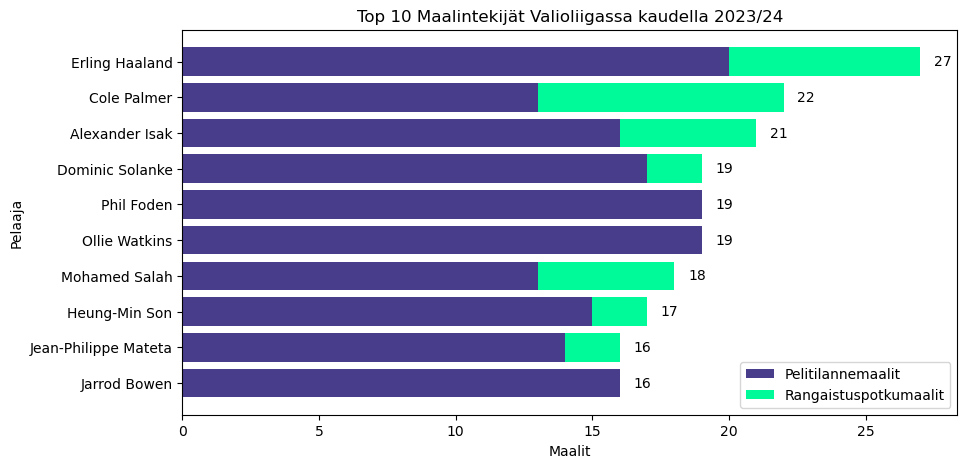

In [9]:
plt.figure(figsize=(10, 5))

allStatsByGoalsDF = allStatsDF.sort_values(
    by="Total Goals", ascending=False
)

# palkit 
barsGoals = (plt.barh(
    allStatsByGoalsDF["Player"][:10], 
    allStatsByGoalsDF["Total Goals"][:10], 
    label="Pelitilannemaalit",
    color="darkslateblue")
) 
barsPenalties = (plt.barh(
    allStatsByGoalsDF["Player"][:10], allStatsByGoalsDF["Penalties"][:10], 
    left=allStatsByGoalsDF["Total Goals"][:10] - allStatsByGoalsDF["Penalties"][:10], 
    label="Rangaistuspotkumaalit",
    color="mediumspringgreen")
)
# labelit ja otsikko
plt.xlabel("Maalit")
plt.ylabel("Pelaaja")
plt.title("Top 10 Maalintekijät Valioliigassa kaudella 2023/24")
plt.gca().invert_yaxis()

# selite maalien kokonaismäärästä 
for bar in barsGoals:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, 
             f"{int(bar.get_width())}", va="center")

plt.legend()
plt.show()


### 2. Interaktiivinen kuvaaja Plotly Expressillä

Kokeillaan samalla datalla rakentaa interaktiivinen pylväskaavio [Plotly](https://plotly.com/python)-kirjaston avulla.
- (Plotly pylväskaaviot -tutoriaali: https://plotly.com/python/bar-charts/)
- (Plotly Express pylväskaavioiden dokumentaatio: https://plotly.com/python-api-reference/generated/plotly.express.bar.html#plotly.express.bar)

In [10]:
# Muutetaan ("sulatetaan") dataFrame wide formatista long formatiin, 
# jotta se sopii Plotly Expressin käyttöön ja uudelleennimetään sarakkeet suomeksi kuvaajaa varten
meltedTop10DF = allStatsByGoalsDF[:10].rename(
    columns={
        'Player': 'Pelaaja',
        'Non-Penalty Goals': 'Pelitilannemaalit', 
        'Penalties': 'Rangaistuspotkumaalit'
    }
).melt(
    id_vars='Pelaaja', 
    value_vars=['Pelitilannemaalit', 'Rangaistuspotkumaalit'], 
    var_name='Maalityyppi', 
    value_name='Määrä'
)

fig2 = px.bar(
    meltedTop10DF,
    x='Määrä',
    y='Pelaaja',
    color='Maalityyppi',
    orientation='h',
    title="Top 10 Maalintekijät Valioliigassa kaudella 2023/24",
    color_discrete_map={'Pelitilannemaalit': 'darkslateblue', 'Rangaistuspotkumaalit': 'mediumspringgreen'}
)
fig2.update_layout(
    barmode='stack',  # pinottu pylväsdiagrammi (toimii ilmankin)
    yaxis=dict(autorange="reversed"),  # käänteinen y:n järjestys
    autosize=False,
    width=1000
)
fig2.show()

Kuvaajassa voi nyt esim. valita näkyviin haluamansa maalityypin (klikkaamalla maalityyppiä legendissä -> päälle/pois), hiiri palkin päälle viemällä selite näkyviin jne.

### 3. Dynaaminen kuvaaja Dashilla (+ Plotly Express)

Lisätään Plotly Expressillä toteutettuun kuvaajaan liukusäädin, jolla voi säätää näytettävien maalintekijöiden määrää. Ts. kuvaaja näyttää dynaamisesti sliderin valinnan mukaan 5-20 parasta maalintekijää. 

- *Dash Python User Guide: https://dash.plotly.com/*
- *Dash Graphing Library: https://plotly.com/python/reference/layout/#layout-title*

In [11]:
app = Dash(__name__)

# Apin html-layout   
app.layout = html.Div([
    html.Div(
        children=[
            html.Div(
                # label
                children="Valitse näytettävien pelaajien määrä:",
                style={
                    "backgroundColor": "white",
                    "textAlign": "center",
                    "fontFamily": '"Open Sans", verdana, arial, sans-serif',
                    "fontSize": 14,
                }
            ),
            # slider
            dcc.Slider(
                id="top-n-slider",
                min=5,
                max=20,
                step=1,
                value=10,
                marks={i: str(i) for i in range(5, 21)},
            )
        ],
        # wrapper sliderille ja labelille
        style={
            "backgroundColor": "white",
            "padding": "40px",
            "width": "920px", # 1000px - padding 
            "display": "grid",
            "gridTemplateColumns": "200px 1fr",
            "gridGap": "20px",
            "alignItems": "center",
            "font": {}
        }
    ),
    dcc.Graph(
        id="top-scorers-plot",
    )
])

# Callback plotin päivittämiseen
@app.callback(
    Output("top-scorers-plot", "figure"),
    Input("top-n-slider", "value")
)
def update_plot(n):
    # Filtteröidään top n pelaajaa ja uudelleennimetään sarakkeet suomeksi
    filteredDF = allStatsByGoalsDF[:n].rename(
        columns={
            "Player": "Pelaaja",
            "Non-Penalty Goals": "Pelitilannemaalit",
            "Penalties": "Rangaistuspotkumaalit"
        }
    ).melt(
        id_vars="Pelaaja",
        value_vars=["Pelitilannemaalit", "Rangaistuspotkumaalit"],
        var_name="Maalityyppi",
        value_name="Määrä"
    )
    # Päivitetty kuvaaja
    fig = px.bar(
        filteredDF,
        x="Määrä",
        y="Pelaaja",
        color="Maalityyppi",
        orientation="h",
        title=f"Top {n} Maalintekijät Valioliigassa 2023/24",
        color_discrete_map={"Pelitilannemaalit": "darkslateblue", "Rangaistuspotkumaalit": "mediumspringgreen"}
    )
    fig.update_layout(
        barmode="stack",
        yaxis=dict(autorange="reversed"),
        autosize=False,
        width=1000,
        height=max(400, n * 35) # korkeus pelaajamäärän n mukaan
    )
    return fig

# Ajetaan Dash-appi
if __name__ == "__main__":
    app.run(debug=True)

## Analyysi (ML perusteita hyödyntäen)

### K-Means Klusterointi

Testataan klusteroida xG:n ja kokonaismaalien perusteella.

- *SKLearn KMeans Demoja: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#gallery-examples*

In [ ]:
# Valitaan klusteroinnin kannalta oleelliset muuttujat
X = allStatsDF[["Expected Goals (xG)", "Total Goals"]].values

# Etsitään optimaalinen klusterien määrä elbow methodin avulla
wcss = []  # WCSS = "Within-Cluster Sum of Squares" -> ns. inertia/"virhe" klustereiden sisällä

# Testataan klustereiden määrää 1-10 ja tallennetaan WCSS-arvot listaan
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=11, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Kuvaaja elbow methodista
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Klustereiden lkm")
plt.ylabel("WCSS")
plt.show()

Kuvaajan perusteella valitaan klustereiden määräksi 4 (WCSS ei enää merkittävästi pienene tätä suuremmalla lkm:llä). Tehdään klusterointi, lisätään dataframeen ja visualisoidaan Plotlyllä. Lisätään kuvaajaan myös y=x -suora, joka jakaa pelaajat yli- ja alisuoriutuneisiin pelaajiin suhteessa maaliodottamaan.

In [13]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=11, n_init=10)
y_kmeans = kmeans.fit_predict(X)
allStatsDF["Cluster (xG-Goals)"] = y_kmeans

# Muutetaan klusterit kategorisiksi muuttujiksi plottia varten
allStatsDF["Cluster (xG-Goals)"] = allStatsDF["Cluster (xG-Goals)"].astype(str)

# Plotly scatter plot
fig = px.scatter(
    allStatsDF,
    x="Expected Goals (xG)",
    y="Total Goals",
    color="Cluster (xG-Goals)",
    title="K-Means klusterointi & Pelaajien suorituminen suhteessa maaliodottamaan",
    hover_data=["Player", "Team", "Expected Goals (xG)", "Total Goals"]
)
# y=x 
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=max(allStatsDF["Expected Goals (xG)"]),
    y1=max(allStatsDF["Expected Goals (xG)"]),
    line=dict(color="black", dash="dot"),
    xref="x",
    yref="y"
)

fig.update_layout(
    xaxis_title="Maaliodottama (xG)",
    yaxis_title="Tehdyt maalit"
    # xaxis=dict(range=[0, None]),
    # yaxis=dict(range=[0, None])
)

fig.show()


c:\Users\mikae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



<div class="alert alert-info">
    Voit valita tai poistaa klustereita näkyvistä kuvaajassa klikkaamalla klusterin nimeä selitteessä - pelaajan tiedot näät viemällä hiiren kuvaajan pisteen päälle.
</div>

Klusteroinnin perusteella saadaan esiin neljä rypästä: matalan maaliodottaman puolustajat (klusteri 0); pääosin keskikenttäpelaajista koostuva alle kymmenen toteutuneen maalin ryhmä (klusteri 1); sekä kaksi runsaasti maaleja tehneiden ryhmää (klusterit 2 ja 3), jotka eroavat toisistaan erityisesti maaliodottaman, mutta keskimäärin myös maalimäärän suhteen.

Erityisesti klusterit 2 ja 3 ovat mielenkiintoisia tarkasteltavia xG:n ja toteutuneiden maalien osalta, sillä ne sisältävät pääosin hyökkääviä pelaajia joiden suoriutumista arvioidaan vahvasti maalien kautta. Kuvaajaan piirretty suora jakaa siis erityisesti hyökkääjät tilastollisesti yli- ja alisuoriutuneisiin pelaajiin: viivan alle jäävät pelaajat ovat olleet viimeistelyssään tehottomia, kun taas viivan yläpuolelle jäävät ovat onnistuneet tekemään maaleja odotuksia paremmin. Mielenkiintoista on mm. se, että moni top 15 maalintekijöistä jää viivan alapuolelle.

Määritetään vielä 10 kaikkein heikoiten ja parhaiten performoitunutta hyökkääjää suhteessa xG:hen:

In [14]:
allStatsDF["Difference of Goals to xG"] = allStatsDF["Total Goals"] - allStatsDF["Expected Goals (xG)"]


filteredDF = allStatsDF[allStatsDF["Cluster (xG-Goals)"].isin(["2", "3"])]
mostBelow = filteredDF.nsmallest(10, "Difference of Goals to xG")
mostAbove = filteredDF.nlargest(10, "Difference of Goals to xG")
# display(mostBelow[['Player', 'Team', "Expected Goals (xG)", "Total Goals", "Difference of Goals to xG"]])
# display(mostAbove[['Player', 'Team', "Expected Goals (xG)", "Total Goals", "Difference of Goals to xG"]])

filteredPlayers = pd.concat([mostBelow, mostAbove])

fig = px.scatter(
    filteredPlayers,
    x="Expected Goals (xG)",
    y="Total Goals",
    color="Cluster (xG-Goals)",
    title="Yli- ja alisuoriutuneimmat hyökkääjät",
    hover_data=["Player", "Team", "Expected Goals (xG)", "Total Goals", "Difference of Goals to xG"],
)

fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=max(filteredPlayers["Expected Goals (xG)"]),
    y1=max(filteredPlayers["Expected Goals (xG)"]),
    line=dict(color="black", dash="dot"),
    xref="x",
    yref="y"
)

fig.update_layout(
    xaxis_title="Maaliodottama (xG)",
    yaxis_title="Tehdyt maalit"
)

fig.show()


### Random Forest -ennustin

Koulutetaan lopuksi malli, joka ennustaa pelaajien FotMob -ratingin.

In [15]:
# Käytetään vain pelaajia, joilla on datassa FotMob rating
filteredStatsDF = allStatsDF[allStatsDF["FotMob Rating"] > 0]

# Mallin selittäjät ("featuret")
X = filteredStatsDF[[
     "Expected Goals (xG)", "Total Goals", "Non-Penalty Goals", "Penalties", "Goals per 90 Min", 
    "Expected Assists (xA)", "Actual Assists", "Assists per 90 Min",  
    "Big Chances Created", "Yellow Cards", "Red Cards"]]
y = filteredStatsDF["FotMob Rating"]

# Jaetaan satunnaisesti koulutus- ja testidataan (20% testidataksi)
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=666)

# Alustetaan ja koulutetaan
model = RandomForestRegressor(n_estimators=1000, random_state=456)
model.fit(trainX, trainY)

# Ennustetaan
predY = model.predict(testX)

# Evaluoidaan malli
mse = mean_squared_error(testY, predY)
r2 = r2_score(testY, predY)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.07757794651887084
R^2 Score: 0.37586438184160753


Mallin keskineliövirheeksi (MSE) saatiin n. 0,078, ja selitysasteeksi kohtalainen 37,5 %. Selitysaste on yllättävänkin hyvä, huomioiden, että data ei suoraan tarjoa mahdollisuutta pelipaikkakohtaiseen tarkasteluun, jolloin datassa on mukana myös paljon esimerkiksi puolustajia ja maalivahteja, joiden suoriutumisen arviointi esim. maalien tai syöttöjen perusteella ei ole mielekästä.

## Yhteenveto
Tässä projektissa analysoitiin jalkapallon Valioliigan kauden 2023/24 pelaajien suoriutumista hyödyntäen Pythonin datankäsittely- ja visualisointityökaluja sekä koneoppimisen perusteita. Projekti sisälsi seuraavat vaiheet:

- Datan lukeminen ja siivoaminen: Datasetti ladattiin GitHubista ja yhdistettiin useista CSV-tiedostoista yhdeksi DataFrameksi. Puuttuvat arvot korvattiin nollilla, ja dataa muokattiin lisäämällä uusia sarakkeita, kuten "Non-Penalty Goals" ja "Goals per 90 Min".

- Datan visualisointi / EDA: Dataan tutustuttiin tarkemmin pelaajien suorituksia kolmella eri tavalla visualisoiden: Matplotlib, Plotly Express ja yksinkertainen Dash-appi.
- Klusterointi: K-Means-klusteroinnin avulla pelaajat ryhmiteltiin maaliodottaman (xG) ja toteutuneiden maalien perusteella. Klusterit visualisoitiin interaktiivisella scatter-plotilla, joka korosti yli- ja alisuoriutuneita pelaajia.

- Koneoppiminen: Random Forest -malli koulutettiin ennustamaan pelaajien FotMob-ratingia heidän tilastojensa perusteella. Mallin suorituskyky arvioitiin, ja se saavutti kohtalaisen selitysasteen (R² = 37,5 %).

Projektin tulokset tarjoavat yleiskuvan pelaajien suorituksista ja mahdollistavat syvällisemmän analyysin esimerkiksi hyökkääjien tehokkuuteen liittyen, tarjoten erinomaisen pohjan jatkokehitykselle.